In [ ]:
%cd code
import torch
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from my_dataset import RoadDataset
from _mydataset import TestDataset
import os, sys
import train_helpers as th
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from torch.utils.data import DataLoader
import cv2
from sklearn.metrics import f1_score
import mask_to_submission

from model import *


%run -i model.py
%run -i my_dataset.py
%run -i train_helpers.py
%run -i mask_to_submission.py


TRAIN_IMG_DIR = "Data/training/train/images"
TRAIN_MASK_DIR = "Data/training/train/groundtruth"
VAL_IMG_DIR = "Data/training/val/images"
VAL_MASK_DIR = "Data/training/val/groundtruth"
ROOT_DIR = os.path.join('Data', 'training')
IMG_DIR = os.path.join(ROOT_DIR, 'images')

TEST_IMG_DIR = "Data/test_set_images"
MASK_DIR= os.path.join(ROOT_DIR, 'groundtruth')

val_img,val_mask = th.extract_val_image_mask(val_img_dir=VAL_IMG_DIR, val_mask_dir=VAL_MASK_DIR)


c:\Users\mathi\anaconda3\envs\ML_torch\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## **VALIDATION_SET**


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "saved_models\VBest_best.pth"
model = AttU_Net().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


val_transform = A.Compose([
        A.Normalize(mean=[0.0, 0.0, 0.0],std=[1.0, 1.0, 1.0],max_pixel_value=255.0,),
        ToTensorV2()
        ])
val_dataset = RoadDataset(
    image_dir=VAL_IMG_DIR,
    mask_dir=VAL_MASK_DIR,
    transform=val_transform,
    patch_size= 400,
    stride= None,
    CLAHE = True
)
val_loader = DataLoader(
    val_dataset,
    batch_size= len(val_dataset),
    shuffle=False, 
    num_workers=0,
)



## **Visualize Validation prediction**

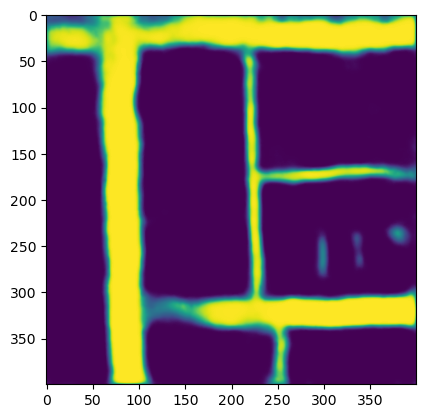

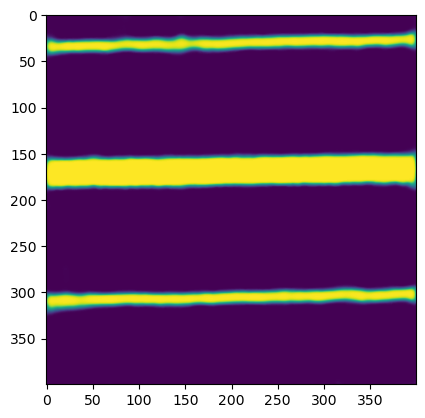

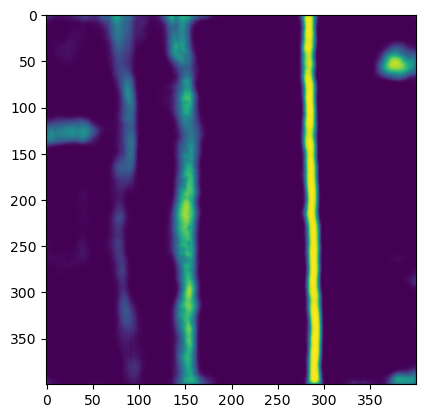

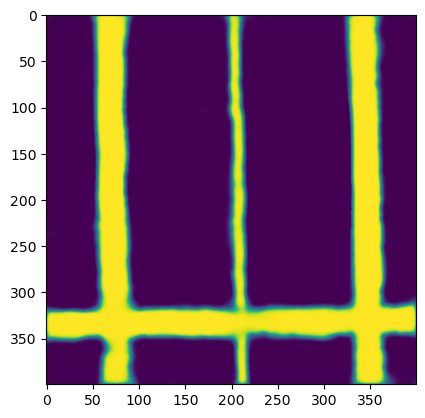

Best Threshold: 0.48310344827586205
Best F1 Score: 0.8963749492277506
Accuracy: 0.9396266666656643


In [3]:
model.eval()
all_preds = []
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.unsqueeze(1)
        outputs = model(images)
        all_preds.append(outputs.cpu().squeeze(1))
all_preds = torch.cat(all_preds, dim=0)
prob_mask = []
for i in range(len(all_preds)):
    image = torch.sigmoid(all_preds[i]).numpy()
    prob_mask.append(image)
for i in range(4):
  plt.imshow(prob_mask[i], cmap='viridis')
  plt.show()

thresholds = np.linspace(0.01, 0.99, 30)  # Test thresholds from 0.1 to 0.9
best_threshold, best_f1, accuracy = th.find_optimal_threshold_global(val_mask, prob_mask, thresholds)

print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1}")
print(f"Accuracy: {accuracy}")

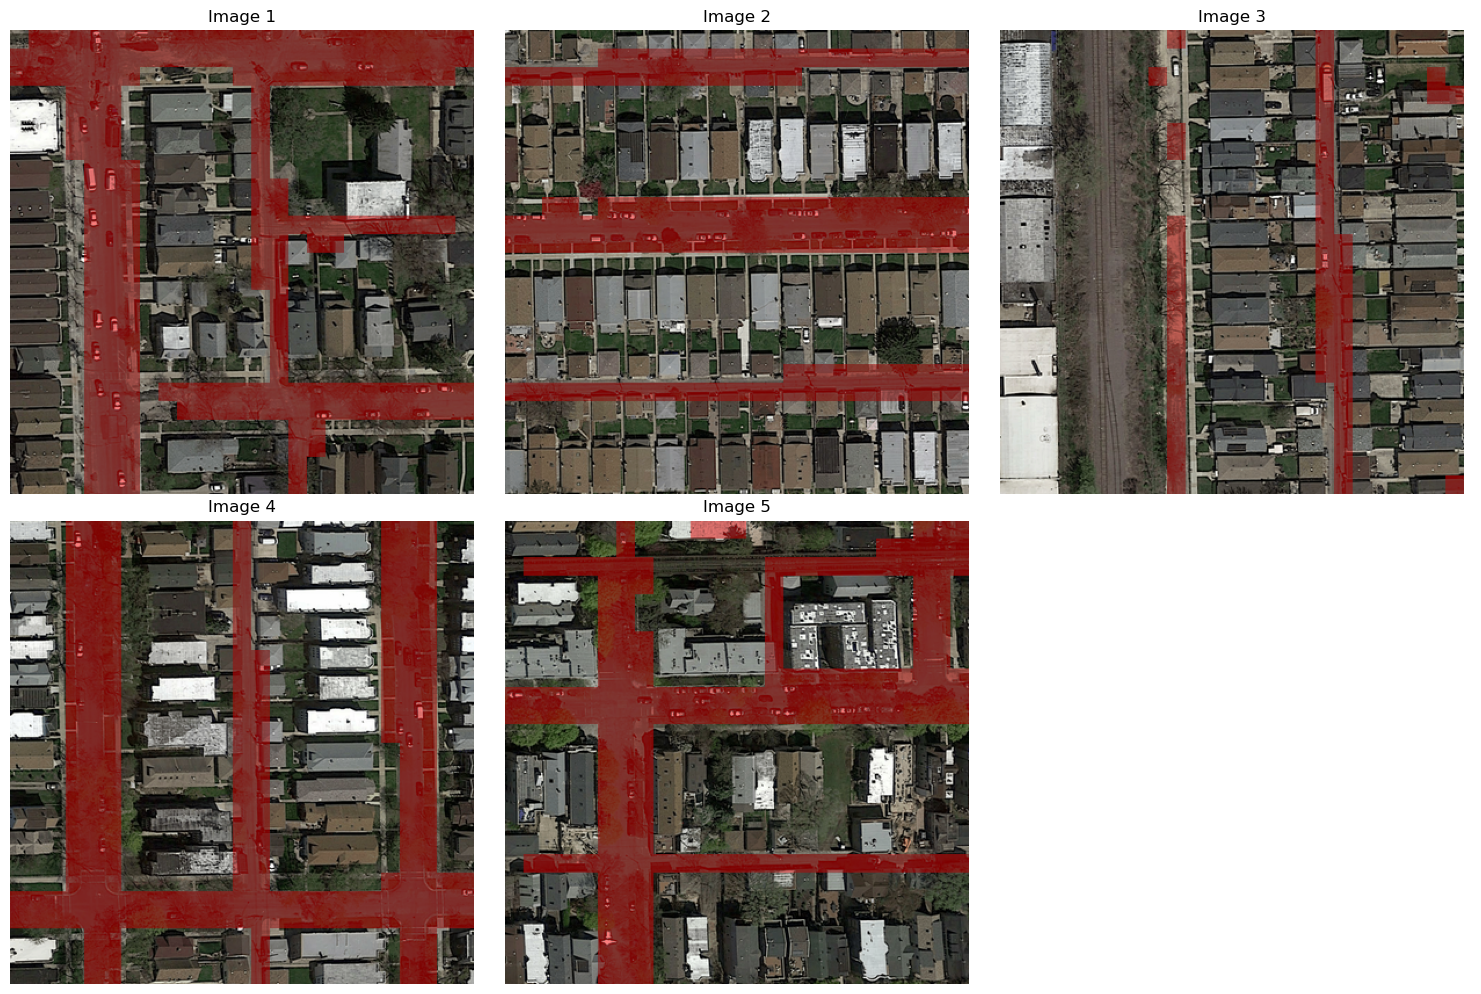

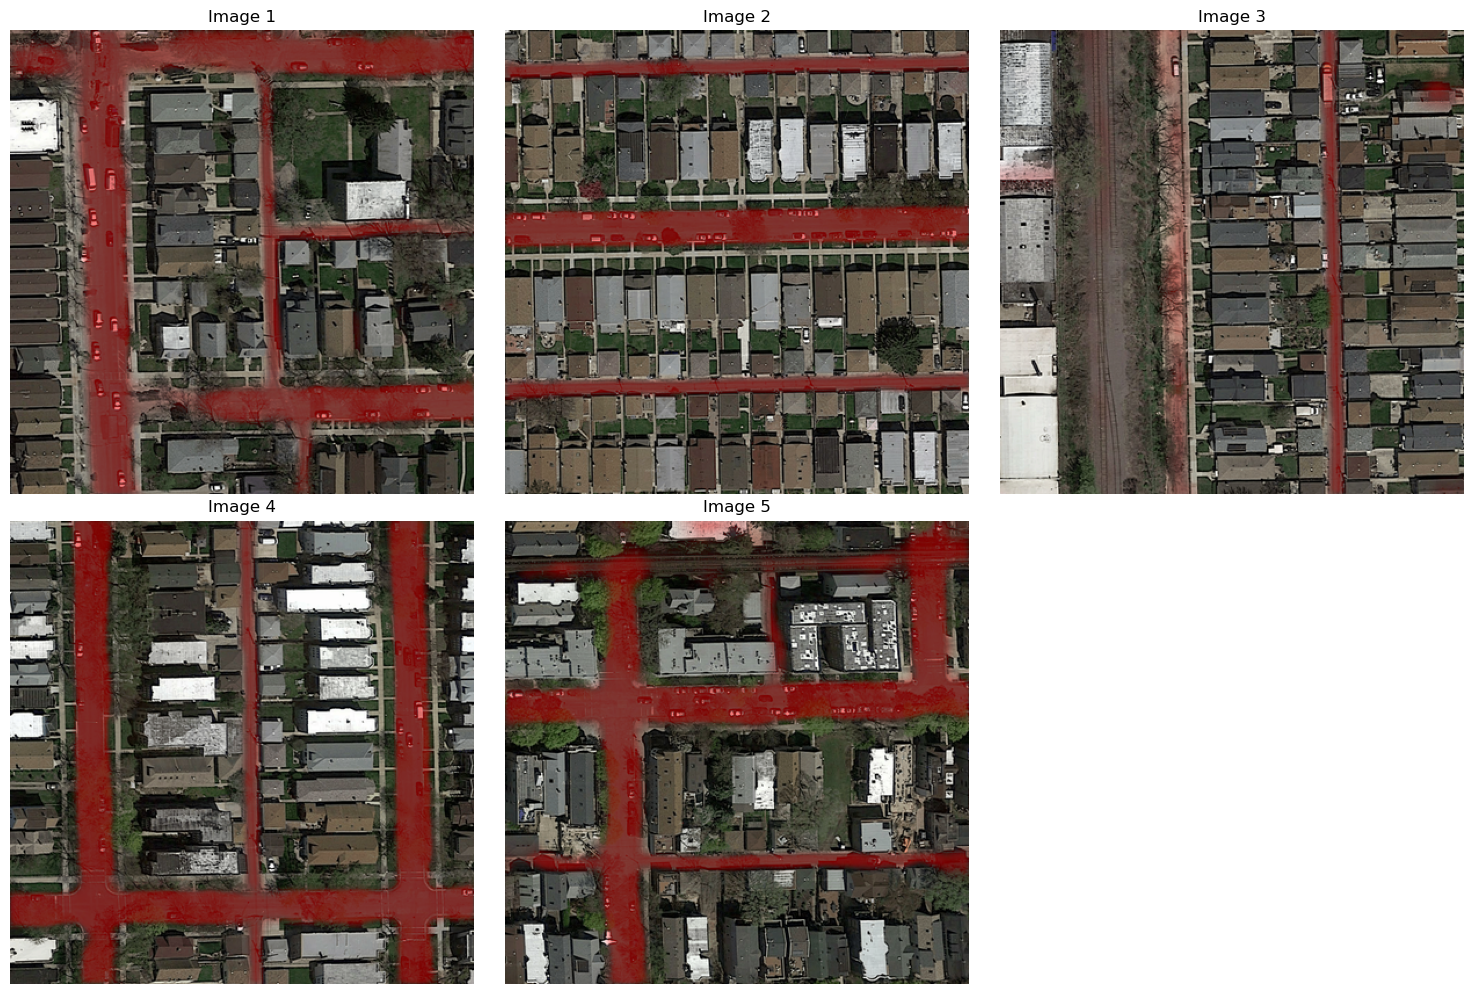

In [4]:
example_image = val_img[:5]
example_pred_prob = prob_mask[:5]
binary_mask = (example_pred_prob > best_threshold).astype(int)
binary_list = []
n = 0
for i in binary_mask:
    binary_list.append(th.reconstruct_full_mask_from_patches(mask_to_submission_format(i, patch_size=16), patch_size=16))
th.compare_masks_with_images(example_image, binary_list, alpha=0.5, num_display=5)
th.compare_masks_with_images(example_image, prob_mask[:5], alpha=0.5, num_display=5)

In [6]:
TEST_IMG_DIR = "/content/drive/MyDrive/Random_Additional_Data/test_set_images" #"/content/drive/MyDrive/Data/test_set_images"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "saved_models\VBest_best.pth"
model = AttU_Net().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

test_transform = A.Compose([
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    ToTensorV2(),
])
CLAHE = True
patch  = 608
stride = None
test_dataset = TestDataset(root_dir=TEST_IMG_DIR, transform=test_transform, patch_size=patch, stride= stride, CLAHE= CLAHE)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1)

model.eval()
all_predictions = []
paths = []
with torch.no_grad():
    for images, path in test_loader:
        images = images.to(device)
        outputs = model(images)
        all_predictions.append(outputs.cpu().squeeze(1))
        paths.append(path)
#all_predictions= torch.cat(all_predictions, dim=0)

prob = [i.numpy() for i in all_predictions]
for n,i in enumerate(prob):
    if n < 5 :
        plt.imshow(th.sigmoid(i), cmap="viridis")
        plt.show()
final_mask = []
print(paths)
for prob, path in zip(prob, paths):
    prediction = (prob >  best_threshold).astype(np.uint8) #(prob >  best_threshold)
    filename = os.path.basename(path[0]).replace(".png", "_mask.png")
    output_path = os.path.join("/content/drive/MyDrive/predictions", filename)
    plt.imsave(output_path, prediction, cmap="gray")
    final_mask.append(prediction)

[]


## **Testing and Submission**

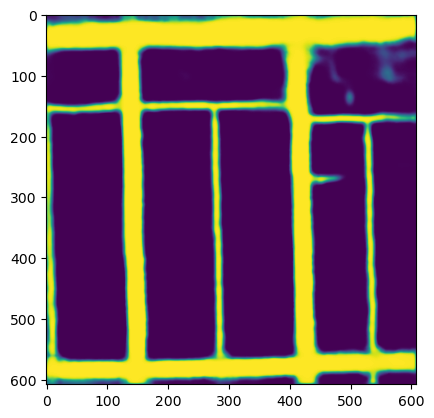

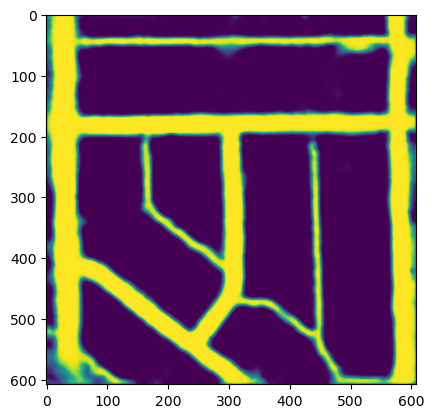

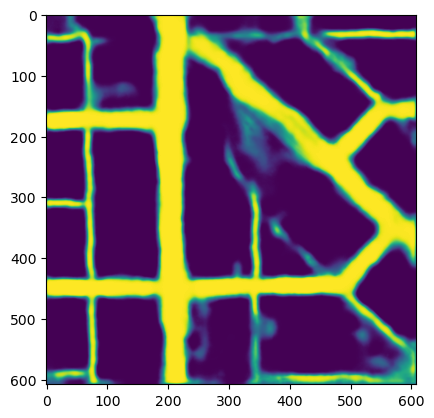

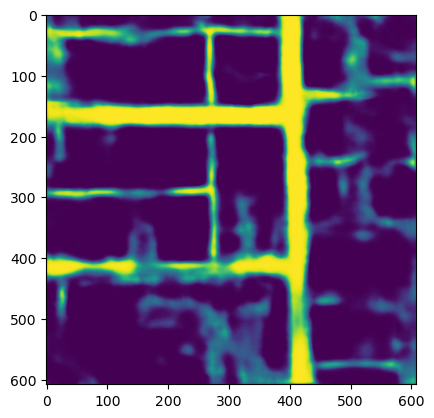

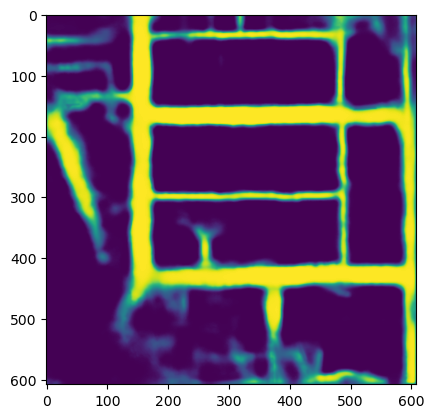

[('Data/test_set_images\\test_1\\test_1.png',), ('Data/test_set_images\\test_10\\test_10.png',), ('Data/test_set_images\\test_11\\test_11.png',), ('Data/test_set_images\\test_12\\test_12.png',), ('Data/test_set_images\\test_13\\test_13.png',), ('Data/test_set_images\\test_14\\test_14.png',), ('Data/test_set_images\\test_15\\test_15.png',), ('Data/test_set_images\\test_16\\test_16.png',), ('Data/test_set_images\\test_17\\test_17.png',), ('Data/test_set_images\\test_18\\test_18.png',), ('Data/test_set_images\\test_19\\test_19.png',), ('Data/test_set_images\\test_2\\test_2.png',), ('Data/test_set_images\\test_20\\test_20.png',), ('Data/test_set_images\\test_21\\test_21.png',), ('Data/test_set_images\\test_22\\test_22.png',), ('Data/test_set_images\\test_23\\test_23.png',), ('Data/test_set_images\\test_24\\test_24.png',), ('Data/test_set_images\\test_25\\test_25.png',), ('Data/test_set_images\\test_26\\test_26.png',), ('Data/test_set_images\\test_27\\test_27.png',), ('Data/test_set_images\

In [8]:
TEST_IMG_DIR = "Data/test_set_images"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "saved_models\VBest_best.pth"
model = AttU_Net().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
test_transform = A.Compose([
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    ToTensorV2(),
])

patch  = 608
stride = None
test_dataset = TestDataset(root_dir=TEST_IMG_DIR, transform=test_transform, patch_size=patch, stride= stride, CLAHE= True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1)


model.eval()
all_predictions = []
paths = []
with torch.no_grad():
    for images, path in test_loader:
        images = images.to(device)
        outputs = model(images)
        all_predictions.append(outputs.cpu().squeeze(1))
        paths.append(path)
all_predictions= torch.cat(all_predictions, dim=0)

prob = [i.numpy() for i in all_predictions]
for n,i in enumerate(prob):
    if n < 5 :
        plt.imshow(sigmoid(i), cmap="viridis")
        plt.show()
final_mask = []
print(paths)
for prob, path in zip(prob, paths):
    prediction = (prob >  best_threshold).astype(np.uint8) #(prob >  best_threshold)
    # filename = os.path.basename(path[0]).replace(".png", "_mask.png")
    # output_path = os.path.join("/content/drive/MyDrive/predictions", filename)
    # plt.imsave(output_path, prediction, cmap="gray")
    final_mask.append(prediction)






In [ ]:
# path_test_img = []
# sum = 0
# for im, path in test_loader:
#   path_test_img.append(path[0])
#   sum += 1
#   if sum == 20:
#     break
# test_image = [th.load_image(path) for path in path_test_img]

# test_pred = final_mask[:21]
# binary_list = []
# for i in test_pred:
#     binary_list.append(th.reconstruct_full_mask_from_patches(th.mask_to_submission_format(i, patch_size=16), patch_size=16))
# th.compare_masks_with_images(test_image, binary_list, alpha=0.5, num_display=20)
# th.compare_masks_with_images(test_image, test_pred, alpha=0.5, num_display=20)

In [ ]:

# TEST_IMG_DIR = "predictions"
# SUBMISSION_FILE_NAME = 'prediction_name.csv'
# image_filenames = []
# for i in range(1, 51):
#     image_filename = os.path.join(TEST_IMG_DIR,f"test_{i}_mask" + '.png')
#     print(image_filename)
#     image_filenames.append(image_filename)
# mask_to_submission.masks_to_submission(SUBMISSION_FILE_NAME, *image_filenames)